In [51]:
import sys
sys.path.append('../')

import tensorflow as tf

from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import lib.utils as utils
import os
import cv2
import random
from keras.models import load_model

In [ ]:
def convertImg(image, size=(32,32)):
    image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    converted = np.zeros(shape=(size[0], size[1], 1))
    for y in range(0, len(image)):
        for x in range(0, len(image[y])):
            converted[y][x][0] = image[y][x]

    converted = converted/255
    return converted

In [ ]:
# trainImages / Images
ratio = 0.7
train_data = []
test_data = []

class_names = os.listdir('./../resources/trainData_new')
print(class_names)

for class_name in class_names:
    data = os.listdir('./../resources/trainData_new/{class_name}'.format(class_name=class_name))
    for i in range(0, len(data)):
        image = convertImg(utils.loadImage(path='./../resources/trainData_new/{class_name}'.format(class_name=class_name), name=data[i], resize=(32,32)))
        #image = convertImg(utils.loadImage(path='./trainData/{class_name}'.format(class_name=class_name), name=data[i], resize=(32,32)))

        label = [0 for i in range(0,len(class_names))]# + 4)]
        #if 'u' in data[i]: label[len(label)-4] = 1
        #if 'd' in data[i]: label[len(label)-3] = 1
        #if 'l' in data[i]: label[len(label)-2] = 1
        #if 'r' in data[i]: label[len(label)-1] = 1
        label[class_names.index(class_name)] = 1

        if(i/len(data) < ratio):
            train_data.append((image,label))
        else:
            test_data.append((image,label))

#class_names += ['up', 'down', 'left', 'right']
print(class_names)

random.shuffle(train_data)
random.shuffle(test_data)

train_images = []
train_labels = []
test_images = []
test_labels = []

for data in train_data:
    train_images.append(data[0])
    train_labels.append(data[1])

for data in test_data:
    test_images.append(data[0])
    test_labels.append(data[1])


train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

print(len(train_images))
print(len(test_images))

In [ ]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    #plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(1024, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dense(len(class_names)))
model.add(layers.Dense(len(class_names), activation='softmax'))

model.summary()

In [ ]:
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])


model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
              

#history = model.fit(train_images, train_labels, epochs=10, 
#                    validation_data=(test_images, test_labels))

history = model.fit(train_images, train_labels, epochs=20, 
                    validation_data=(test_images, test_labels))


In [49]:
#model.save('./../resources/saved_model/my_model')

model.save('./../resources/saved_model/my_model.h5')
del model

# returns a compiled model
# identical to the previous one

In [ ]:
#boxes = [[[45,118],[80,184]],[[250,115],[300,141]]]
#image = utils.loadImage("../src/testImages", "1.png")

def classify(boxes, image):
    
    model = tf.keras.models.load_model('./../resources/saved_model/my_model')

    components = []
    for box in boxes:
        component = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        components.append(convertImg(component).reshape(-1,32,32,1))

    modelPredictions = model.predict(np.vstack(components))

    predictions = []

    for prediction in modelPredictions:
        print(prediction)
        predictions.append(class_names[np.argmax(predictions_single)])
        #predictions.append([class_names[np.argmax(prediction[:-4])],class_names[-4:][np.argmax(prediction[-4:])]])

        #predictions.append(class_names[np.argmax(prediction)])

    return predictions

In [52]:
#model = tf.keras.models.load_model('./../resources/saved_model/my_model')

model = load_model('./../resources/saved_model/my_model.h5')

['capacitor', 'ground', 'inductor', 'resistor', 'voltage']
[1.3936667e-18 2.1133357e-16 1.0000000e+00 1.3062073e-23 5.6967515e-20]
inductor


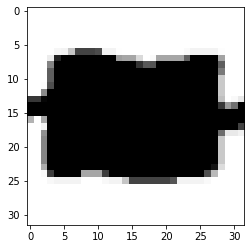

In [53]:

# Check its architecture
#new_model.summary()

#img = convertImg(utils.loadImage(path='./../resources/trainData', name='3.png', resize=(32,32)))

img = test_images[0]
#img = train_images[12]


predictions_single = model.predict(img.reshape(-1,32,32,1))[0]
print(class_names)
print(predictions_single)
print(class_names[np.argmax(predictions_single)])
#print(class_names[np.where(predictions_single[:-4] == np.amax(predictions_single[:-4]))[0][0]])
#print(class_names[np.where(predictions_single[-4:] == np.amax(predictions_single[-4:]))[0][0] + len(class_names) - 4])

plt.imshow(img, cmap='gray')

In [ ]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap='gray')

    predictions_single = model.predict(test_images[i].reshape(-1,32,32,1))[0]
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[np.argmax(predictions_single)])
    #plt.xlabel(class_names[np.where(predictions_single[:-4] == np.amax(predictions_single[:-4]))[0][0]])
plt.show()

In [ ]:
plt.plot(history.history['val_binary_accuracy'], label='val_accuracy')
plt.plot(history.history['binary_accuracy'], label = 'accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=1)
#test_loss, test_acc = model.evaluate(train_images,  train_labels, verbose=1)
print(test_labels)
print(test_acc)
print(test_loss)